In [23]:
%load_ext autoreload
%autoreload 2

In [1]:
from pydantic import BaseModel
from openai import OpenAI
from dotenv import load_dotenv
import openai
import os

# Load environment variables from .env file
load_dotenv()

# Access the API key
openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI()

In [11]:
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from openai import OpenAI
import sys
sys.path.append('.')
from schemas.task import Plan

client = OpenAI()

# Set up the parser
parser = PydanticOutputParser(pydantic_object=Plan)

# Load the task generation prompt template
with open("../prompts/task_generation.md", "r") as f:
    template = f.read()

# Load the original PRD
with open('../resources/PlannerAgentPRD.md', 'r') as f:
    prd_content = f.read()


# Create the prompt template
prompt = PromptTemplate(
    template=template,
    input_variables=["PRD"]
)

formtted_prompt = prompt.format(prd=prd_content)

completion = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": formtted_prompt},
    ],
    response_format=Plan,
)

plan = completion.choices[0].message.parsed
print(f"Generated Plan has {len(plan.tasks)} tasks:\n{plan}")

Generated Plan has 7 tasks:
tasks=[Task(id='TASK-001', title='Finalize Task Data Schemas', description='Develop and finalize the schemas for task data, which should include fields for ID, title, description, dependencies, and estimated hours. Ensure these schemas are ready for integration with the LLM for task generation.', priority=<PriorityLevel.MUST_HAVE: 'must_have'>, depends_on=[], estimate=TaskEstimate(hours=8.0, confidence_level=<ConfidenceLevel.HIGH: 'high'>, story_points=2, notes=None), risk=TaskRisk(level=<RiskLevel.LOW: 'low'>, description='Schemas might need adjustments after initial LLM integration.', mitigation_strategy='Include feedback loops post LLM integration to refine schemas.'), section='6.1 LLM Integration', tags=['schema', 'data_model', 'initial_setup']), Task(id='TASK-002', title='Basic LLM Prompt Engineering for Task Generation', description='Develop and test initial prompt strategies for the LLM to ensure accurate task extraction and generation from the PRD.',

In [12]:
for task in plan.tasks:
    print(f"Generated Task:\n{task.model_dump_json(indent=2)}")

Generated Task:
{
  "id": "TASK-001",
  "title": "Finalize Task Data Schemas",
  "description": "Develop and finalize the schemas for task data, which should include fields for ID, title, description, dependencies, and estimated hours. Ensure these schemas are ready for integration with the LLM for task generation.",
  "priority": "must_have",
  "depends_on": [],
  "estimate": {
    "hours": 8.0,
    "confidence_level": "high",
    "story_points": 2,
    "notes": null
  },
  "risk": {
    "level": "low",
    "description": "Schemas might need adjustments after initial LLM integration.",
    "mitigation_strategy": "Include feedback loops post LLM integration to refine schemas."
  },
  "section": "6.1 LLM Integration",
  "tags": [
    "schema",
    "data_model",
    "initial_setup"
  ]
}
Generated Task:
{
  "id": "TASK-002",
  "title": "Basic LLM Prompt Engineering for Task Generation",
  "description": "Develop and test initial prompt strategies for the LLM to ensure accurate task extra

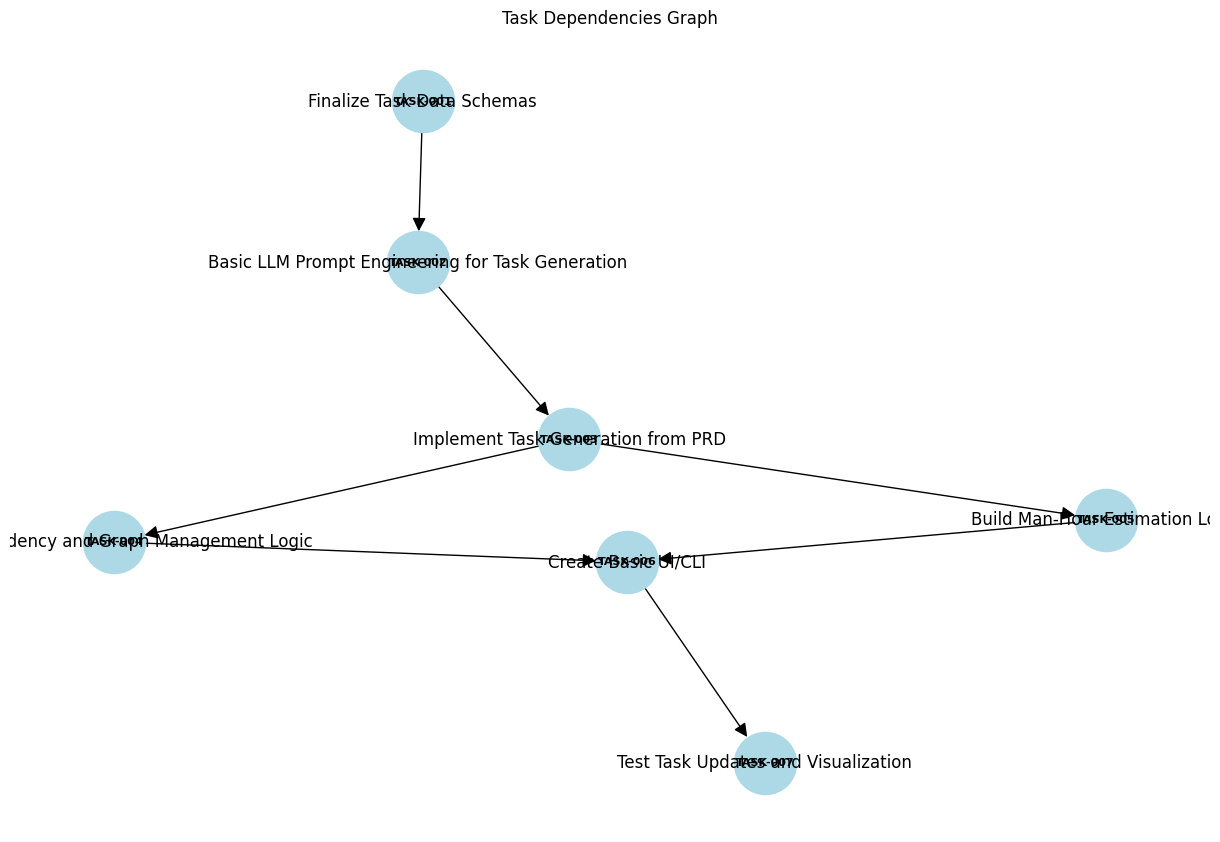

In [13]:
# Create the dependency DAG
import networkx as nx
import matplotlib.pyplot as plt
from helper.dag import create_dependency_dag

# Generate the DAG
dag = create_dependency_dag(plan.tasks)

# Set up the visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(dag)

# Draw the graph
nx.draw(dag, pos, 
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        arrowsize=20,
        font_size=8,
        font_weight='bold')

# Add task titles as labels
labels = {node: dag.nodes[node]['task'].title for node in dag.nodes()}
nx.draw_networkx_labels(dag, pos, labels)

plt.title("Task Dependencies Graph")
plt.axis('off')
plt.show()


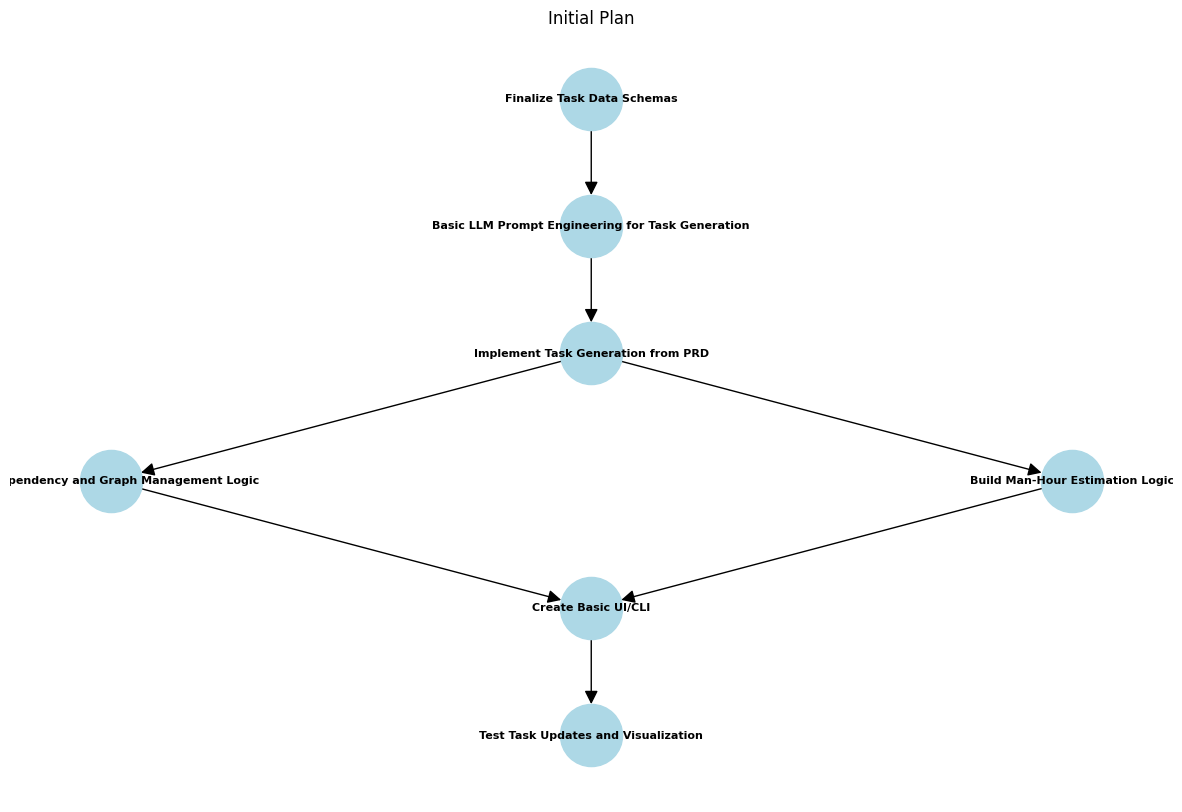

In [55]:
from helper.dag import get_topological_sort

def visualize_dag_hierarchical(dag, topo_sort, title="Task Dependencies Graph"):
    # Calculate node levels based on dependencies
    node_levels = {}
    for node in dag.nodes():
        # Level is the length of longest path to this node
        paths_to_node = []
        for start_node in [n for n in dag.nodes() if dag.in_degree(n) == 0]:
            try:
                paths = list(nx.all_simple_paths(dag, start_node, node))
                paths_to_node.extend(paths)
            except nx.NetworkXNoPath:
                continue
        
        if not paths_to_node:
            node_levels[node] = 0
        else:
            node_levels[node] = max(len(path)-1 for path in paths_to_node)

    # Set up the visualization with hierarchical layout
    plt.figure(figsize=(15, 10))

    # Calculate x coordinates based on levels and y coordinates within each level
    level_counts = {}
    level_positions = {}

    for node in topo_sort:
        level = node_levels[node]
        if level not in level_counts:
            level_counts[level] = 0
        level_counts[level] += 1

    max_nodes_per_level = max(level_counts.values())

    pos = {}
    for node in topo_sort:
        level = node_levels[node]
        if level not in level_positions:
            level_positions[level] = 0
        
        # Y coordinate is based on level (negative to go top-down)
        y = -level
        
        # X coordinate is distributed evenly within the level
        if level_counts[level] > 1:
            x = (level_positions[level] - (level_counts[level] - 1)/2) / level_counts[level]
        else:
            x = 0
        
        pos[node] = (x, y)
        level_positions[level] += 1

    # Draw the graph
    # Display title if provided, otherwise use default
    graph_title = title if title else "Task Dependencies Graph (Hierarchical Layout)"
    plt.title(graph_title)
    
    nx.draw(dag, pos,
            with_labels=False,  # Don't draw default labels
            node_color='lightblue',
            node_size=2000,
            arrowsize=20)

    # Add task titles as labels
    labels = {node: dag.nodes[node]['task'].title for node in dag.nodes()}
    nx.draw_networkx_labels(dag, pos, labels, font_size=8, font_weight='bold')

    plt.axis('off')
    plt.show()

# Get topological sort and visualize
topo_sort = get_topological_sort(dag)
visualize_dag_hierarchical(dag, topo_sort, title="Initial Plan")


In [44]:
from typing import List
from schemas.task import Plan


def get_updated_plan_from_feedback(plan: Plan, user_feedback: str) -> Plan:
    import sys
    sys.path.append('.')

    # Load the task updater prompt template
    with open('../prompts/task_updater.md', 'r') as f:
        task_updater_prompt = f.read()

    # Load the original PRD
    with open('../resources/PlannerAgentPRD.md', 'r') as f:
        prd_content = f.read()

    # Format the current plan as JSON string
    current_tasks_json = plan.model_dump_json(indent=2)

    # Format the task updater prompt with the required inputs
    task_updater_formatted = task_updater_prompt.format(
        prd=prd_content,
        current_tasks=current_tasks_json,
        user_feedback=user_feedback
    )

    # Get updated tasks from LLM
    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": task_updater_formatted}
        ],
        response_format=Plan,
        temperature=0.1
    )

    # Return the updated plan
    return completion.choices[0].message.parsed

def visualize_plan(plan: Plan, title: str = None):
    """
    Creates and visualizes a DAG representation of a task plan.
    
    Args:
        plan: Plan object containing tasks and their dependencies
        title: Optional title for the visualization
    
    Returns:
        The plan object for chaining
    """
    dag = create_dependency_dag(plan.tasks)
    topo_sort = get_topological_sort(dag)
    visualize_dag_hierarchical(dag, topo_sort, title=title)


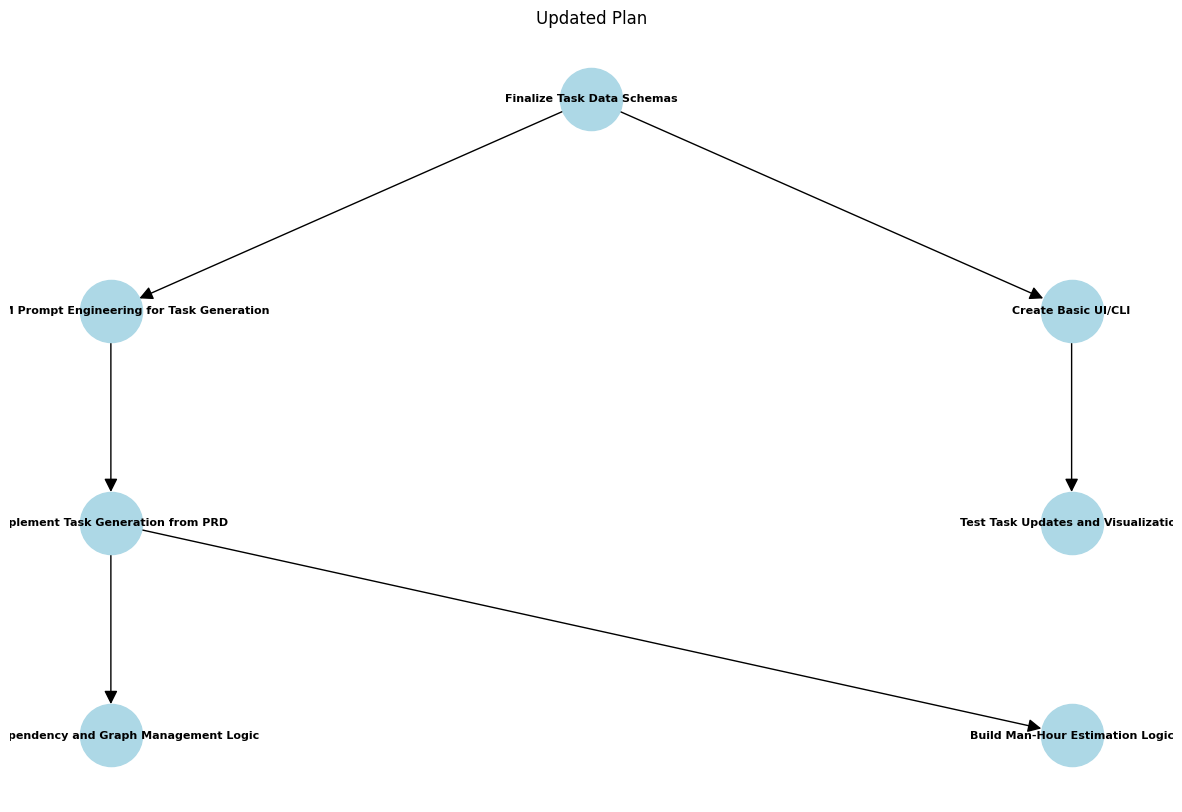

In [50]:
user_feedback = """
Yeah, I believe that we can parallelize the task visualizationUI generation after we finalize the schemas, right?
Because once we have the schemas, we can generate a small mock dataset that we can work from to
build the UI for the visualization of tasks.
"""
updated_plan = get_updated_plan_from_feedback(plan, user_feedback)
visualize_plan(updated_plan, title="Updated Plan")

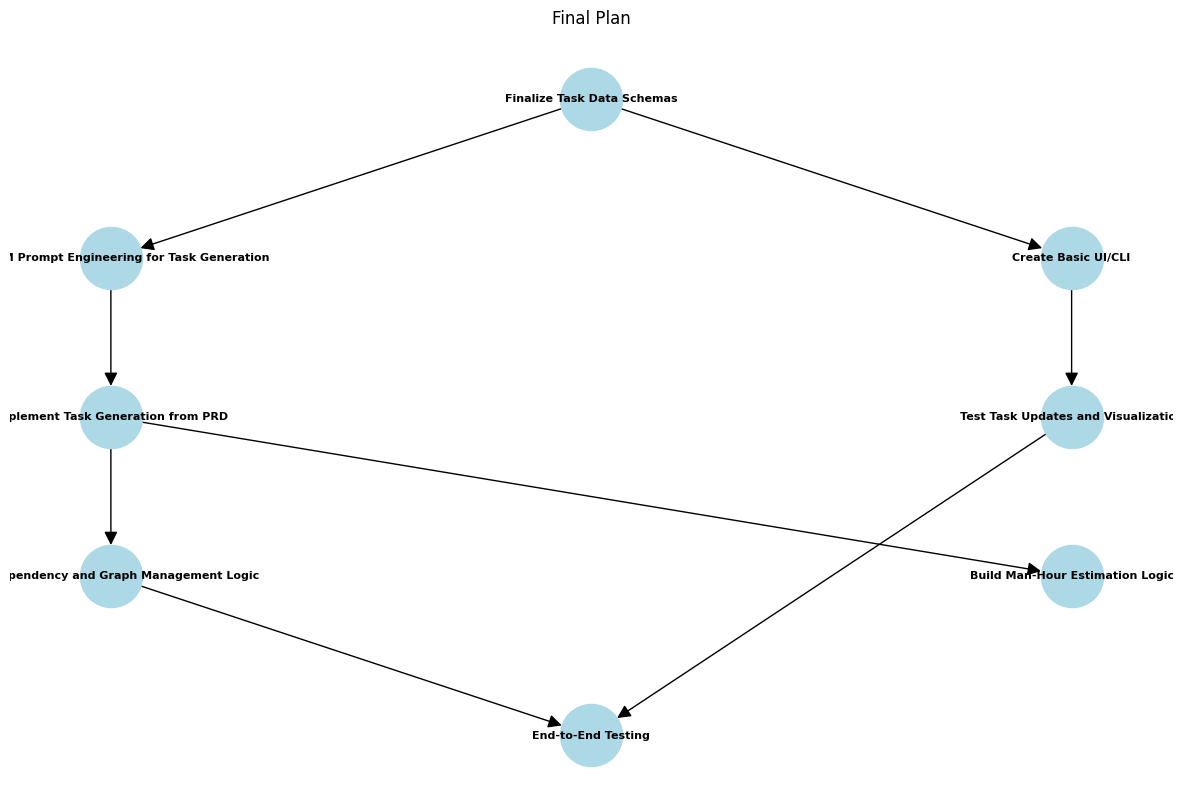

In [54]:
user_feedback = """
Looks great. Now let's add a final end-to-end testing task once we've tested the Dependency and graph management
 logic and the tested the task visualization UI.
"""
final_plan = get_updated_plan_from_feedback(updated_plan, user_feedback)
visualize_plan(final_plan, title="Final Plan")